В этом notebook мы будем работать над улучшением метрик бейслайн моделей, путем дополнительных преобразований с данными.

## 1. Предобработка
Выполняем все те же операции, что и в бейслайне

In [86]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, TargetEncoder
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.base import clone
from lightgbm import LGBMClassifier
from helper import *
from plots import *
import random

In [87]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [46]:
df = pd.read_csv("data.csv")

## 1. Предобработка

In [275]:
df_preprocessed = df.copy()
# Удаляем полные дубликаты строк
df_preprocessed = df_preprocessed.drop_duplicates()
# Удаляем строки с отрицательными значениями таргета Billing Amount
df_preprocessed = df_preprocessed[df_preprocessed['Billing Amount'] >= 0]
df_preprocessed['Age'] = pd.to_numeric(df_preprocessed['Age'])
# Преобразуем даты в тип datetime
df_preprocessed['Date of Admission'] = pd.to_datetime(
    df_preprocessed['Date of Admission'], errors='coerce'
)
df_preprocessed['Discharge Date'] = pd.to_datetime(
    df_preprocessed['Discharge Date'], errors='coerce'
)
# Делаем числовые признаки из даты
df_preprocessed["Admission_Year"]      = df_preprocessed["Date of Admission"].dt.year
df_preprocessed["Admission_Month"]     = df_preprocessed["Date of Admission"].dt.month
df_preprocessed["Admission_DayOfWeek"] = df_preprocessed["Date of Admission"].dt.dayofweek  # 0=Пн

df_preprocessed["Discharge_Year"]      = df_preprocessed["Discharge Date"].dt.year
df_preprocessed["Discharge_Month"]     = df_preprocessed["Discharge Date"].dt.month
df_preprocessed["Discharge_DayOfWeek"] = df_preprocessed["Discharge Date"].dt.dayofweek  # 0=Пн

# Исходную дату выбрасываем
df_preprocessed = df_preprocessed.drop(columns=["Date of Admission"])
df_preprocessed = df_preprocessed.drop(columns=["Discharge Date"])

# удаляем Hospital (тк он имеет 39876 уникальных значений, что очень много), номер комнаты, имя и доктора, тк они не несут какого-то значения
df_preprocessed = df_preprocessed.drop(columns=['Hospital', 'Room Number', "Name", "Doctor"])

[autoreload of helper failed: Traceback (most recent call last):
  File "C:\Users\theea\AppData\Roaming\Python\Python313\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "C:\Users\theea\AppData\Roaming\Python\Python313\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
  File "c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1251.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x98 in position 697: character maps to <undefined>
]


In [276]:
X, y = divide_data(df_preprocessed, 'Billing Amount')

In [277]:
categorical_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']
numeric_cols = ['Age']
category_orders = [
    ['Male', 'Female'], # gender
    ['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-'], # Blood Type                         
    ['Arthritis', 'Diabetes', 'Hypertension', 'Obesity', 'Cancer', 'Asthma'], # Medical Condition    
    ['UnitedHealthcare', 'Cigna', 'Medicare', 'Blue Cross', 'Aetna'], # Insurance Provider        
    ['Urgent', 'Emergency', 'Elective'], # Admission Type
    ['Lipitor', 'Ibuprofen', 'Aspirin', 'Paracetamol', 'Penicillin'], # Medication
    ['Abnormal', 'Normal', 'Inconclusive'], # Test Results
]

# уже знакомый нам пайплайн
preprocessor = Pipeline([ 
    # Кодирование категориальных признаков (зависит от завершения обоих этапов импутации)
    ('transformations', ColumnTransformer(
        transformers=[
            ('encoder',
             OrdinalEncoder(categories=category_orders),
             categorical_cols)
        ],
        remainder='passthrough',  # числовые колонки передаются без изменений
        verbose_feature_names_out=False
    ))
])
preprocessor.set_output(transform="pandas")

,steps,"[('transformations', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [278]:
# сохраним все бейслайн модели в виде списка для удобства
models = [
    ('LinearRegression', LinearRegression()),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=SEED, max_depth=4)),
    ('RandomForestRegressor', RandomForestRegressor(random_state=SEED)),
    ('LGBMRegressor', LGBMRegressor(random_state=SEED))
]

In [61]:
# используем 5-блочную кросс-валидацию, учитывающую распределение таргета при разбиении
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


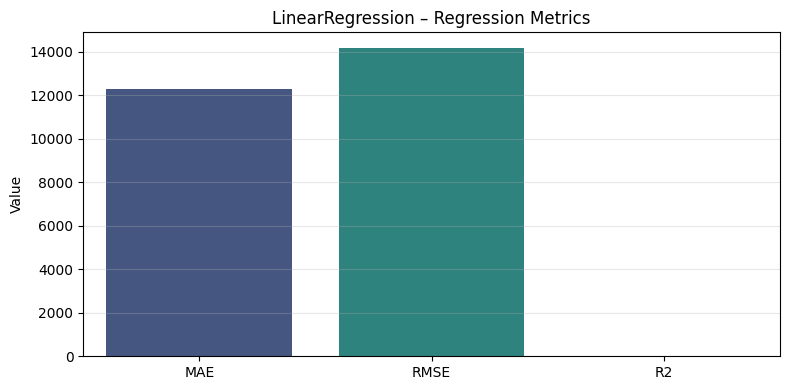

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


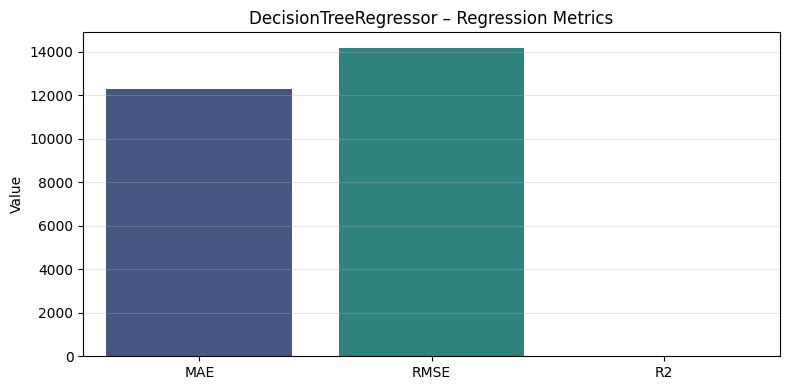

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


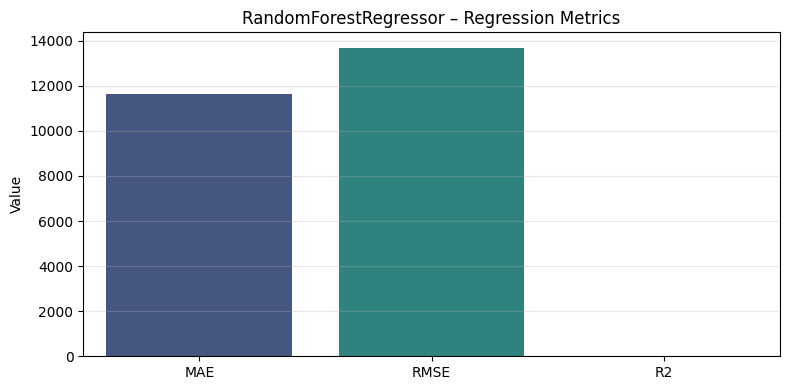

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


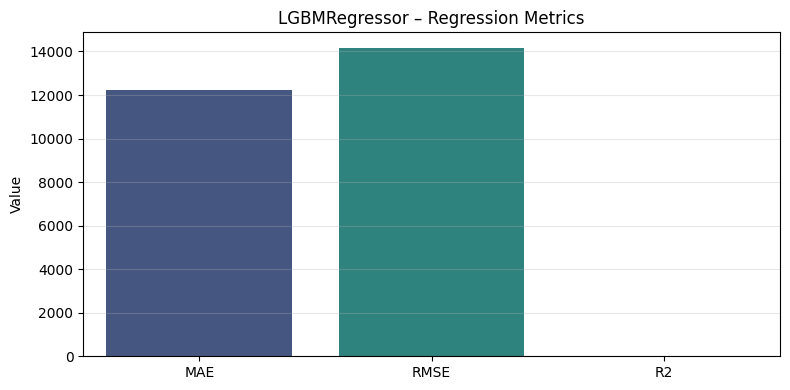

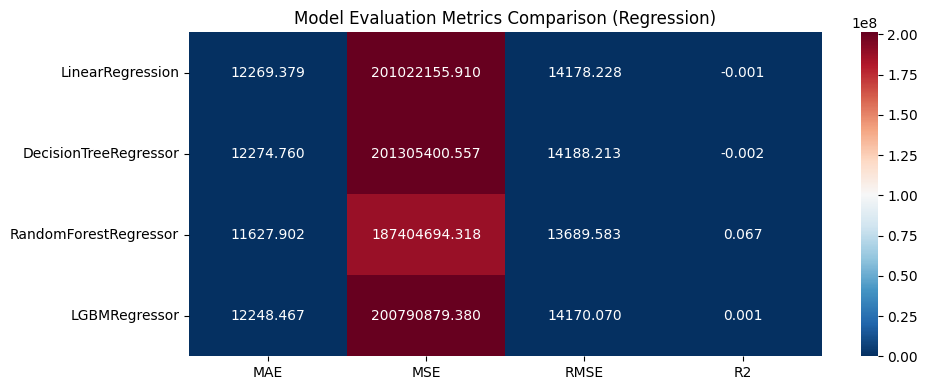

In [62]:
initial_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

## 2. Преобразования данных и feature engineering

### 2.1 Логарифмическое преобразование
Попробуем логарифмировать таргет

In [216]:
from sklearn.compose import TransformedTargetRegressor

In [220]:
def make_log_model(base_model):
    return TransformedTargetRegressor(
        regressor=base_model,
        func=np.log1p,    # y -> log(1 + y)
        inverse_func=np.expm1  # обратно в рубли
    )

log_models = [
    ('LinearRegression',
     make_log_model(LinearRegression())),

    ('DecisionTreeRegressor',
     make_log_model(DecisionTreeRegressor(random_state=SEED, max_depth=4))),

    ('RandomForestRegressor',
     make_log_model(RandomForestRegressor(random_state=SEED))),

    ('LGBMRegressor',
     make_log_model(LGBMRegressor(random_state=SEED))),
]

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


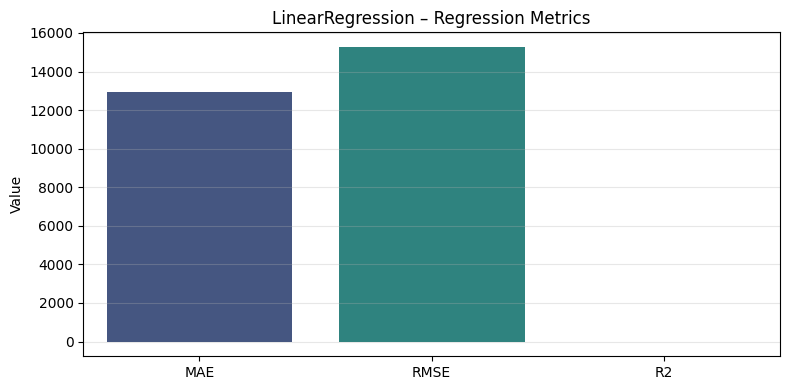

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


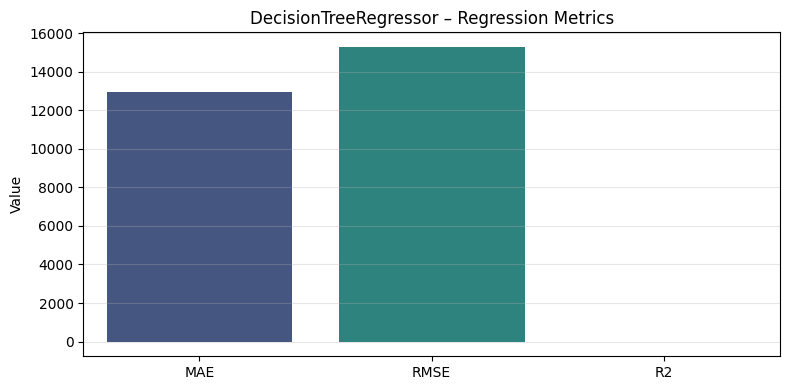

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


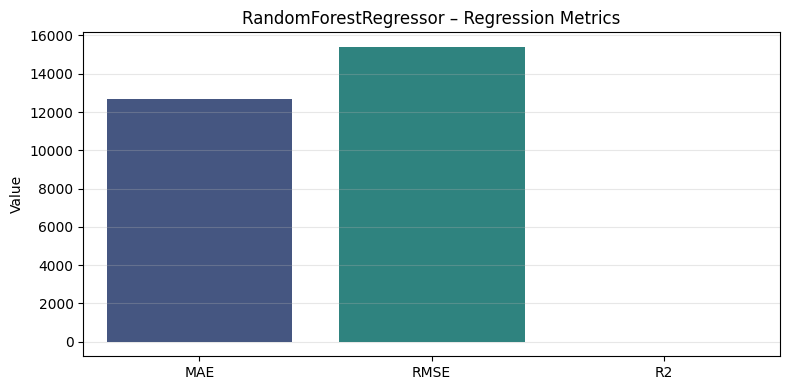

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


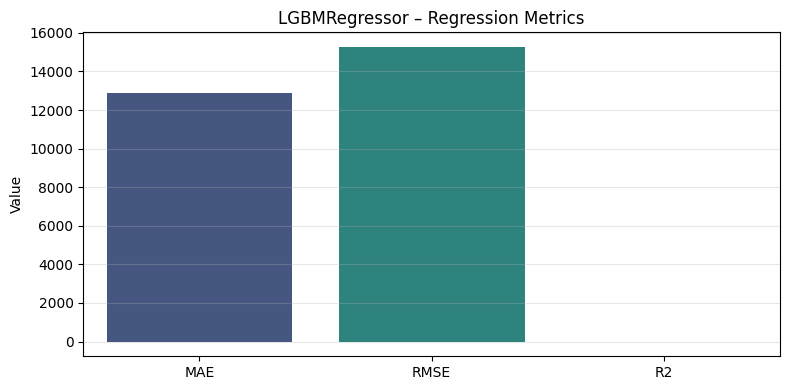

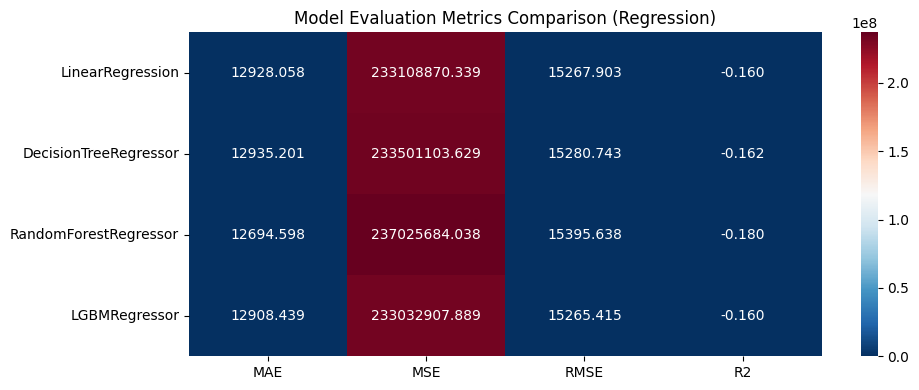

In [221]:
log_metrics = train_evaluate_models_cv(
    models=log_models,
    X=X,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                                MAE         RMSE        R2
 LinearRegression        658.678930  1089.675037 -0.159705
 DecisionTreeRegressor   660.440594  1092.529464 -0.160252
 RandomForestRegressor  1066.695511  1706.055051 -0.246987
 LGBMRegressor           659.972375  1095.345574 -0.160476)

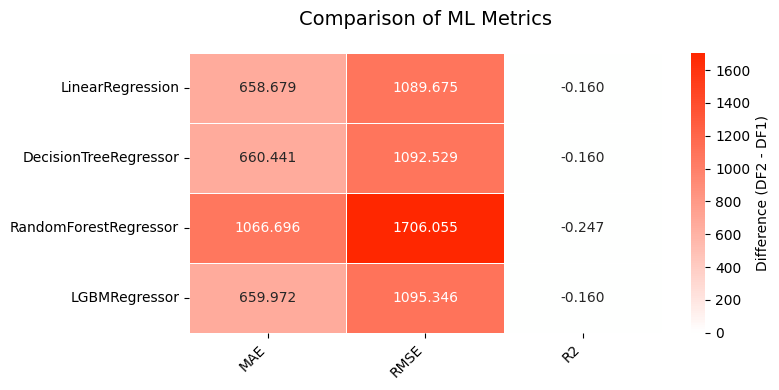

In [222]:
compare_metrics_heatmap(initial_metrics, log_metrics)

везде ухудшения кроме R2

### 2.2 Создание нового признака "Length_of_stay"
Длина пребывания в больнице (в днях)

In [165]:
X_Length_of_stay = df.copy()
# Удаляем полные дубликаты строк
X_Length_of_stay = X_Length_of_stay.drop_duplicates()
# Удаляем строки с отрицательными значениями таргета Billing Amount
X_Length_of_stay = X_Length_of_stay[X_Length_of_stay['Billing Amount'] >= 0]
X_Length_of_stay['Age'] = pd.to_numeric(X_Length_of_stay['Age'])
# Преобразуем даты в тип datetime
X_Length_of_stay['Date of Admission'] = pd.to_datetime(
    X_Length_of_stay['Date of Admission'], errors='coerce'
)
X_Length_of_stay['Discharge Date'] = pd.to_datetime(
    X_Length_of_stay['Discharge Date'], errors='coerce'
)
# Делаем числовые признаки из даты
X_Length_of_stay["Admission_Year"]      = X_Length_of_stay["Date of Admission"].dt.year
X_Length_of_stay["Admission_Month"]     = X_Length_of_stay["Date of Admission"].dt.month
X_Length_of_stay["Admission_DayOfWeek"] = X_Length_of_stay["Date of Admission"].dt.dayofweek  # 0=Пн

X_Length_of_stay["Discharge_Year"]      = X_Length_of_stay["Discharge Date"].dt.year
X_Length_of_stay["Discharge_Month"]     = X_Length_of_stay["Discharge Date"].dt.month
X_Length_of_stay["Discharge_DayOfWeek"] = X_Length_of_stay["Discharge Date"].dt.dayofweek  # 0=Пн

# удаляем Hospital (тк он имеет 39876 уникальных значений, что очень много), номер комнаты, имя и доктора, тк они не несут какого-то значения
X_Length_of_stay = X_Length_of_stay.drop(columns=['Hospital', 'Room Number', "Name", "Doctor"])

In [166]:
X_1, y_1 = divide_data(X_Length_of_stay, 'Billing Amount')

In [167]:
# 3.1 Длина пребывания в больнице (в днях)
X_Length_of_stay1 = X_1.copy()
X_Length_of_stay1['Length_of_stay'] = (
    X_Length_of_stay1['Discharge Date'] - X_Length_of_stay1['Date of Admission']
).dt.days.clip(lower=0)

X_Length_of_stay1 = X_Length_of_stay1.drop(columns=['Date of Admission', 'Discharge Date'])

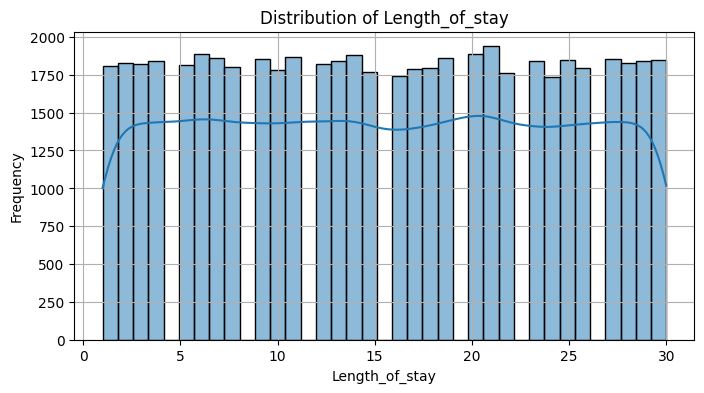

In [168]:
plot_hist_numeric(X_Length_of_stay1, 'Length_of_stay')

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


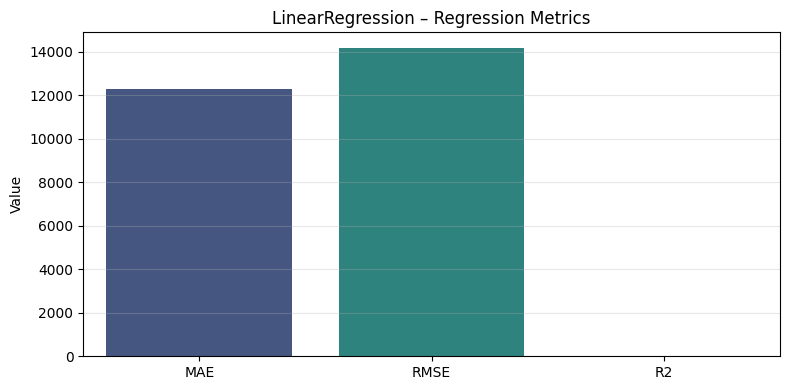

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


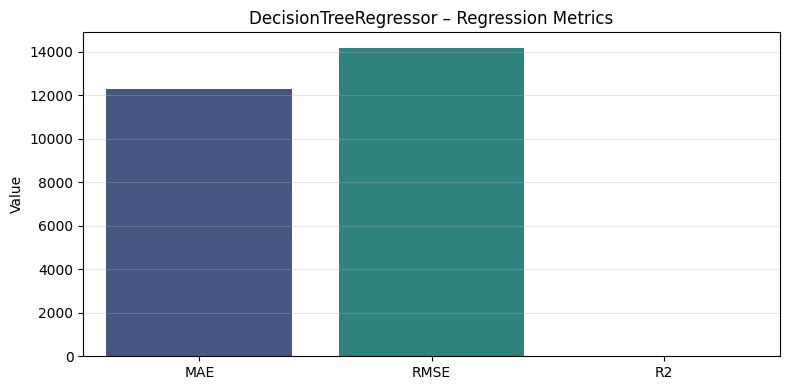

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


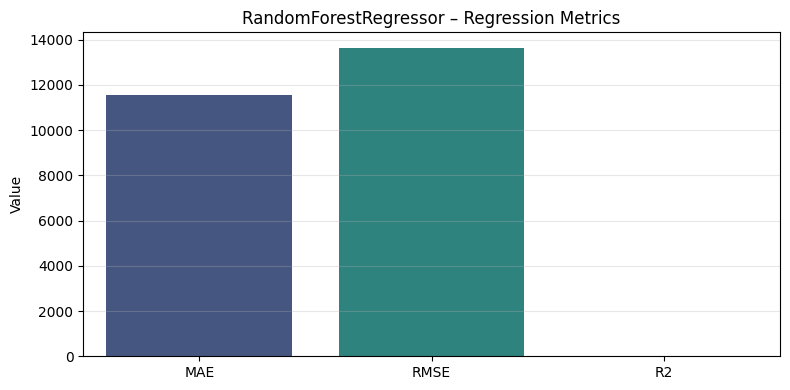

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


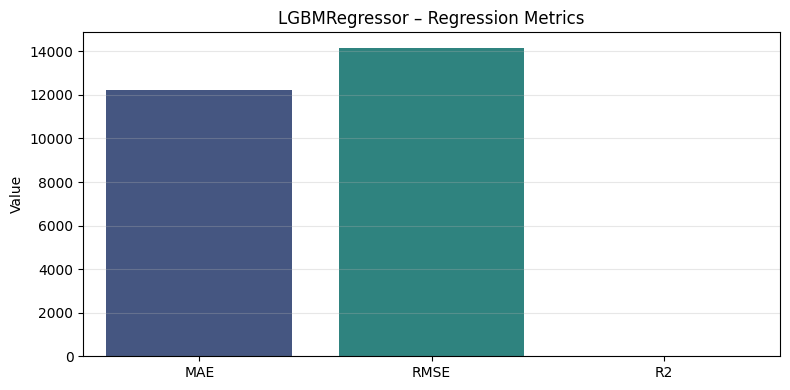

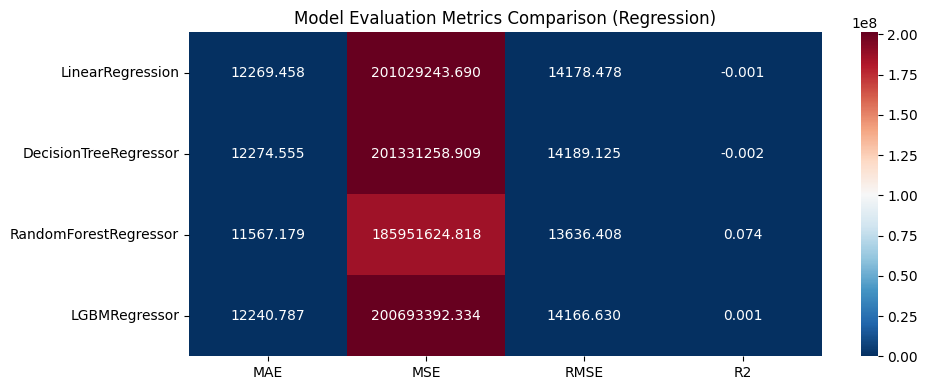

In [169]:
Length_of_stay_metrics = train_evaluate_models_cv(
    models=models,
    X=X_Length_of_stay1,
    y=y_1,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                              MAE       RMSE        R2
 LinearRegression        0.078922   0.249951 -0.000035
 DecisionTreeRegressor  -0.204455   0.911232 -0.000129
 RandomForestRegressor -60.723530 -53.175362  0.007235
 LGBMRegressor          -7.679463  -3.440311  0.000482)

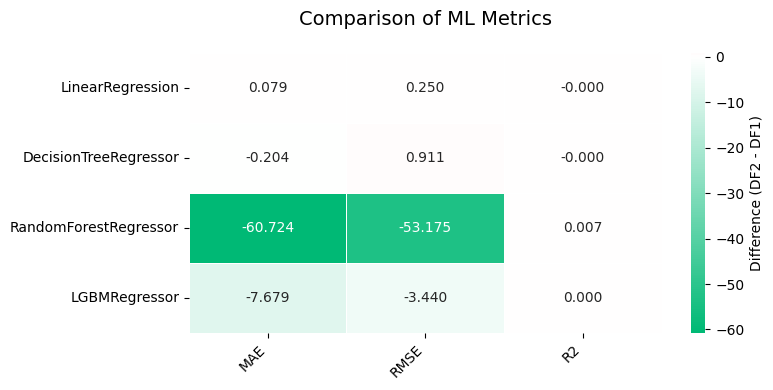

In [170]:
compare_metrics_heatmap(initial_metrics, Length_of_stay_metrics)

особых изменений нет

### 2.3 Возрастные флаги. 

модель может по-разному оценивать счета у детей и пожилых, даже при одинаковом диагнозе

In [171]:
X_age = X.copy()

In [172]:
# ребёнок / взрослый / пожилой
X_age['Is_Child']  = (df_preprocessed['Age'] < 18).astype(int)
X_age['Is_Senior'] = (df_preprocessed['Age'] >= 65).astype(int)


c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


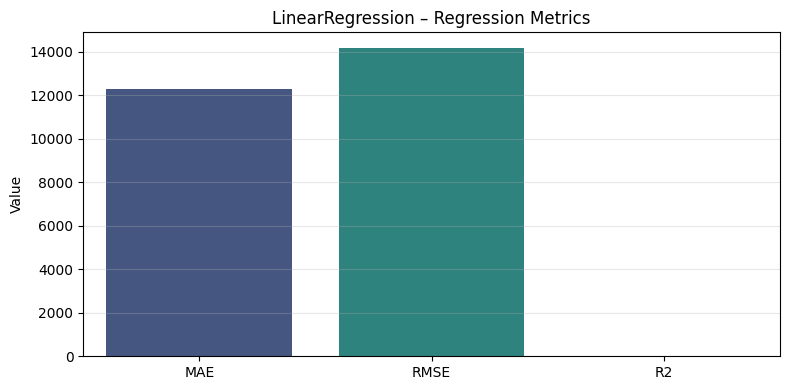

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


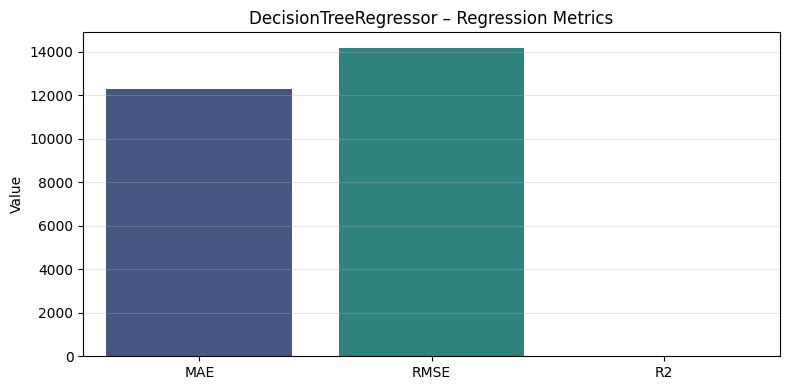

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


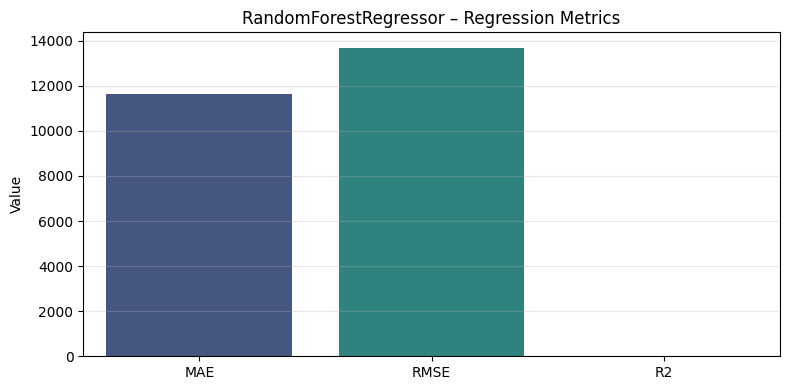

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


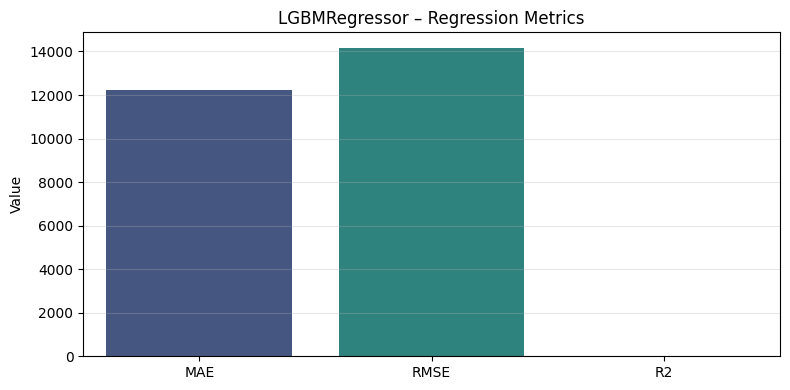

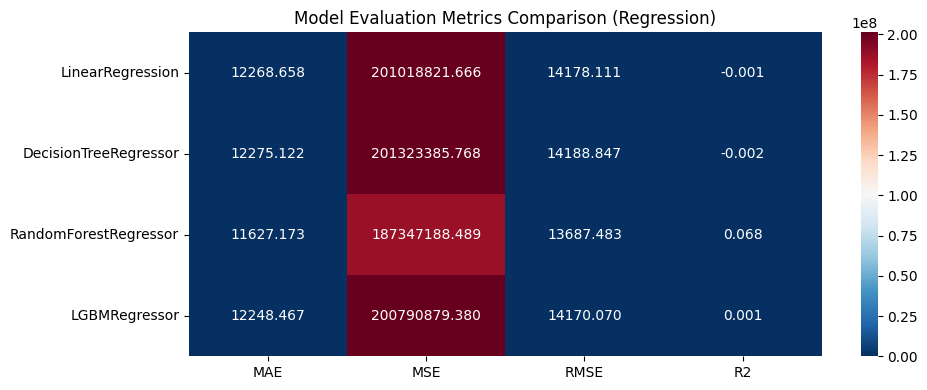

In [173]:
age_metrics = train_evaluate_models_cv(
    models=models,
    X=X_age,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE        R2
 LinearRegression      -0.720975 -0.117584  0.000017
 DecisionTreeRegressor  0.362495  0.633794 -0.000089
 RandomForestRegressor -0.729343 -2.100511  0.000290
 LGBMRegressor          0.000000  0.000000  0.000000)

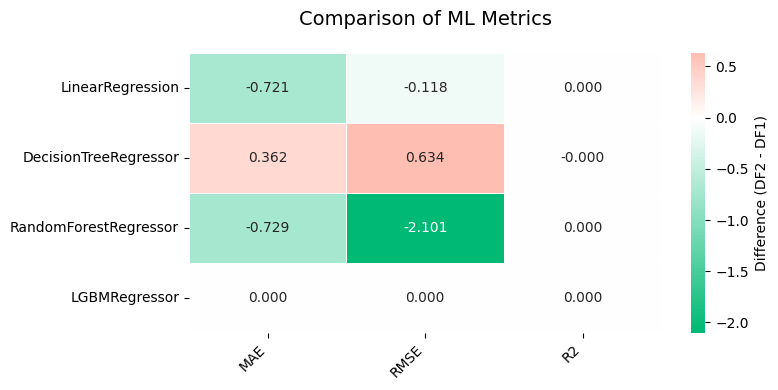

In [174]:
compare_metrics_heatmap(initial_metrics, age_metrics)

особых изменений нет

# «Тяжесть» диагноза

In [175]:
X_risk = X.copy()

In [176]:
high_risk = ['Cancer']
medium_risk = ['Diabetes', 'Hypertension', 'Obesity', 'Asthma']
# остальные считаем низким риском

def condition_risk(cond):
    if cond in high_risk:
        return 3
    if cond in medium_risk:
        return 2
    return 1

X_risk['Condition_Risk'] = X_risk['Medical Condition'].apply(condition_risk)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


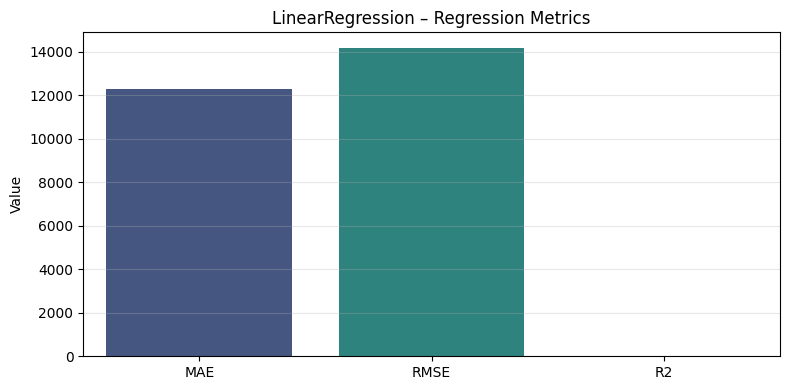

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


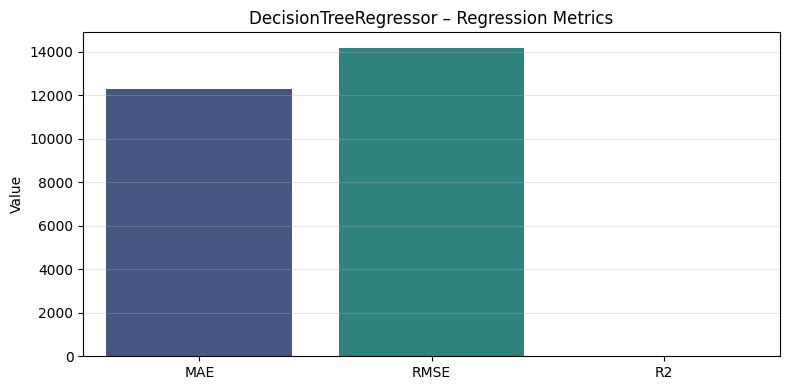

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


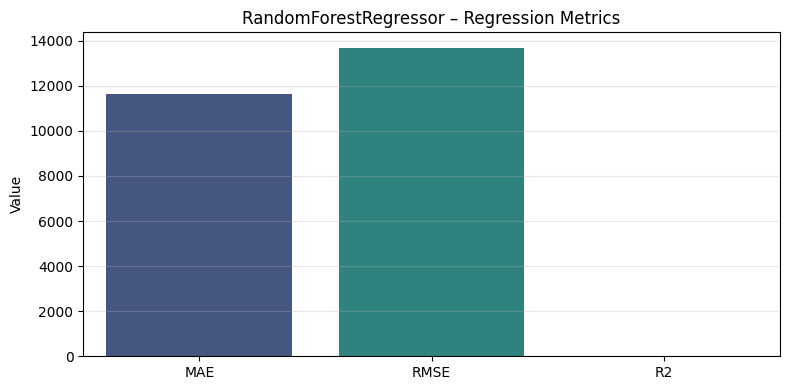

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


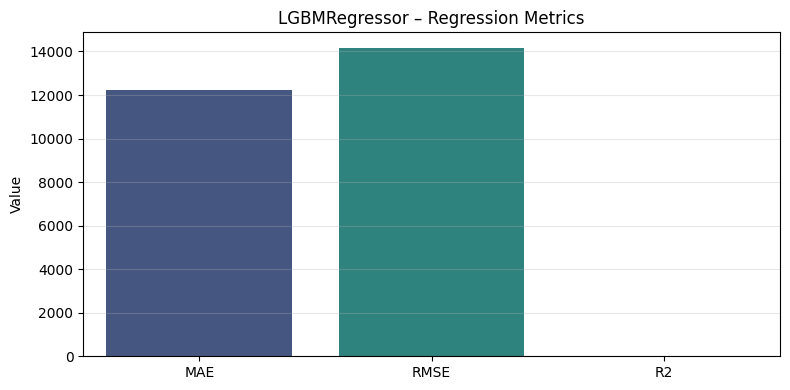

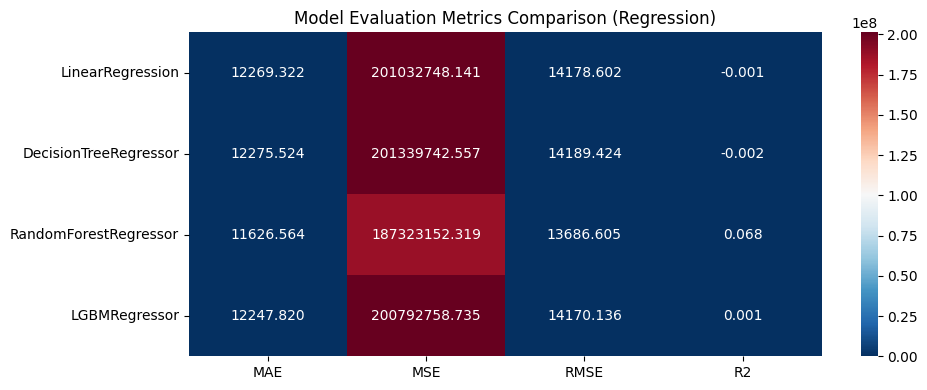

In [177]:
risk_metrics = train_evaluate_models_cv(
    models=models,
    X=X_risk,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE        R2
 LinearRegression      -0.720975 -0.117584  0.000017
 DecisionTreeRegressor  0.362495  0.633794 -0.000089
 RandomForestRegressor -0.729343 -2.100511  0.000290
 LGBMRegressor          0.000000  0.000000  0.000000)

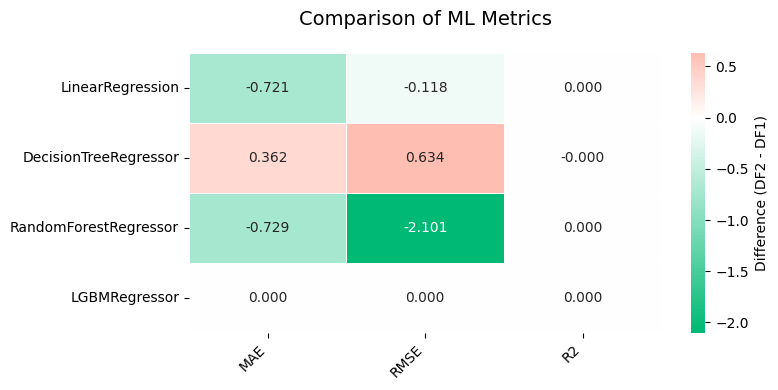

In [178]:
compare_metrics_heatmap(initial_metrics, age_metrics)

### 2.4 Биннинг для Age

#### 2.4.1 Без удаления

In [179]:
X_age_binning = X.copy()

In [180]:
bins = [0, 25, 40, 60, 120]
labels = [0, 1, 2 , 3]

X_age_binning['Age_bins'] = pd.cut(X_age_binning['Age'], bins=bins, labels=labels, right=True)

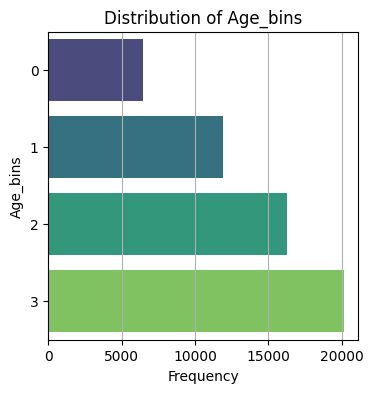

In [181]:
plot_hist_categorical(X_age_binning, 'Age_bins')

In [182]:
preprocessor_age_binning = clone(preprocessor)
preprocessor_age_binning['nan_remover'].transformers[0][2].append('Age_bins')

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


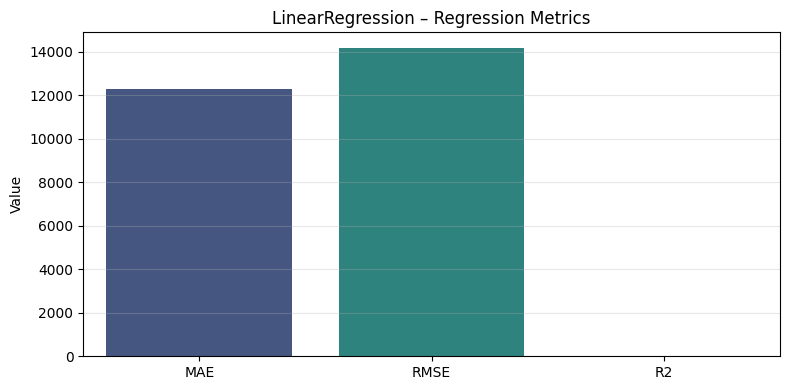

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


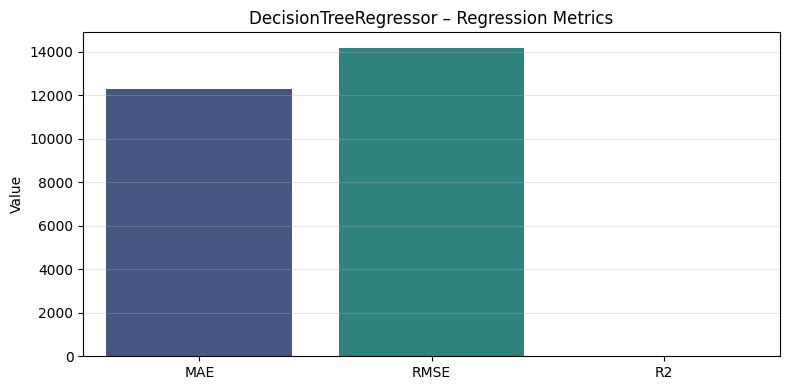

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


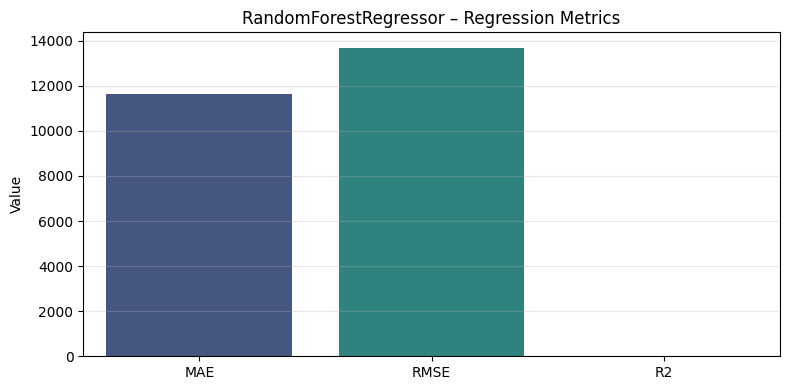

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


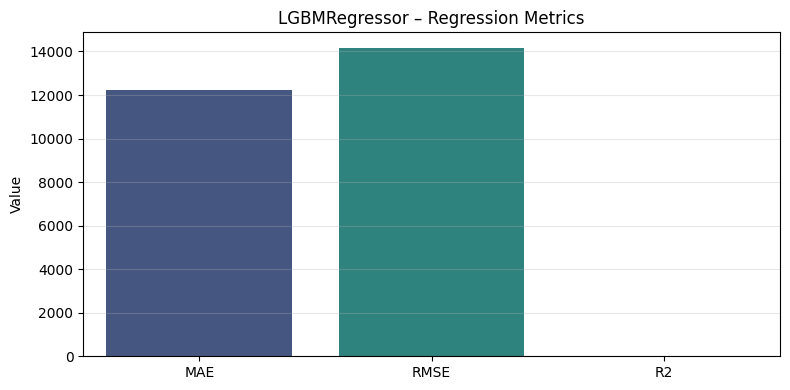

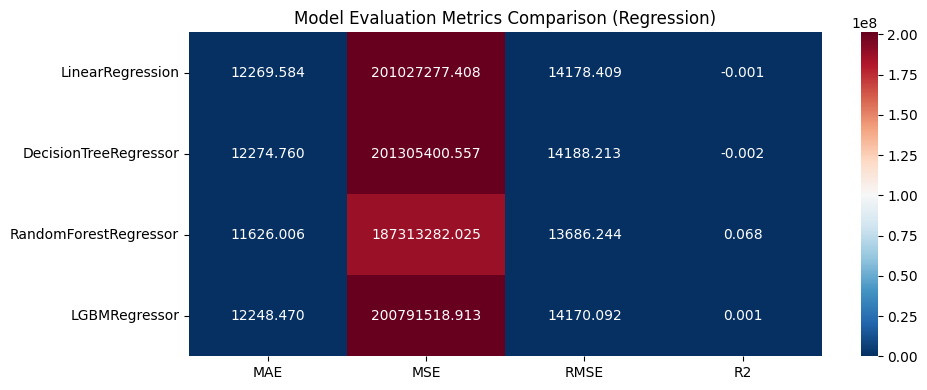

In [183]:
age_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=X_age_binning,
    y=y,
    preprocessor=preprocessor_age_binning,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                             MAE          RMSE            R2
 LinearRegression       0.204564  1.806102e-01 -2.548232e-05
 DecisionTreeRegressor  0.000000 -1.818989e-12  8.890458e-17
 RandomForestRegressor -1.896050 -3.339161e+00  4.545493e-04
 LGBMRegressor          0.002893  2.256630e-02 -3.142902e-06)

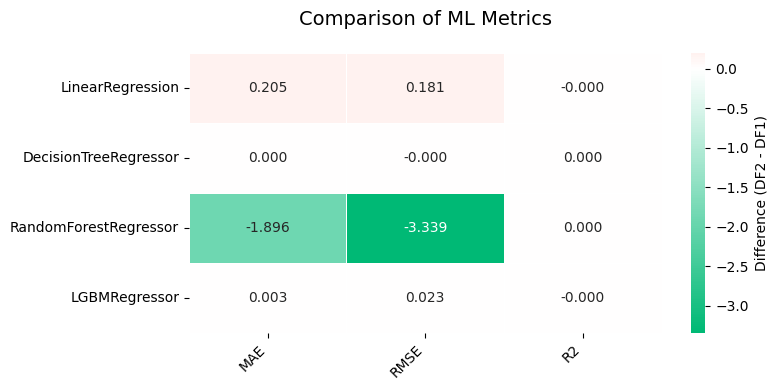

In [184]:
compare_metrics_heatmap(initial_metrics, age_binning_metrics)

ухудшения в лесе

#### 2.4.2 С удалением

In [185]:
X_age_binning_del = X.copy()

In [186]:
bins = [0, 25, 40, 60, 120]
labels = [0, 1, 2 , 3]

X_age_binning_del['Age'] = pd.cut(X_age_binning_del['Age'], bins=bins, labels=labels, right=True)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


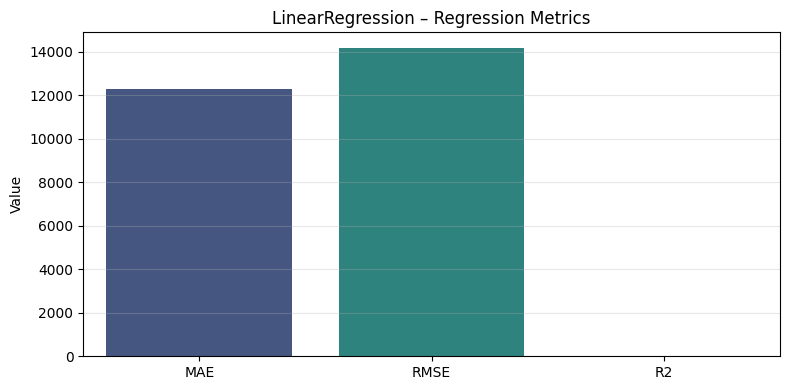

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


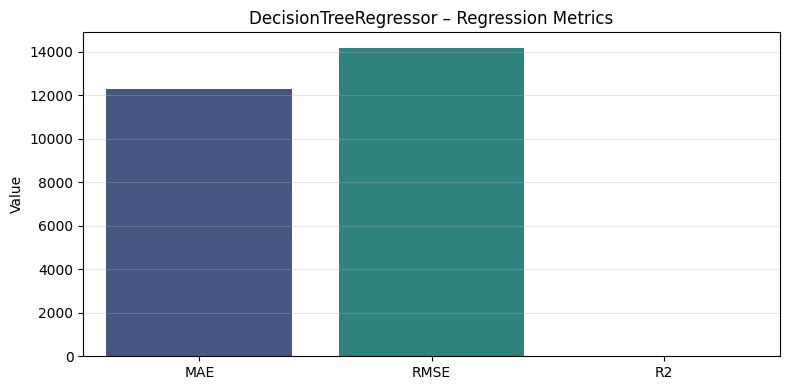

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


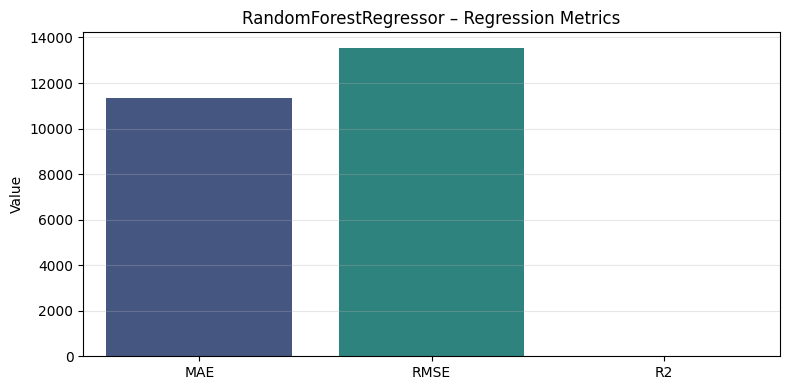

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


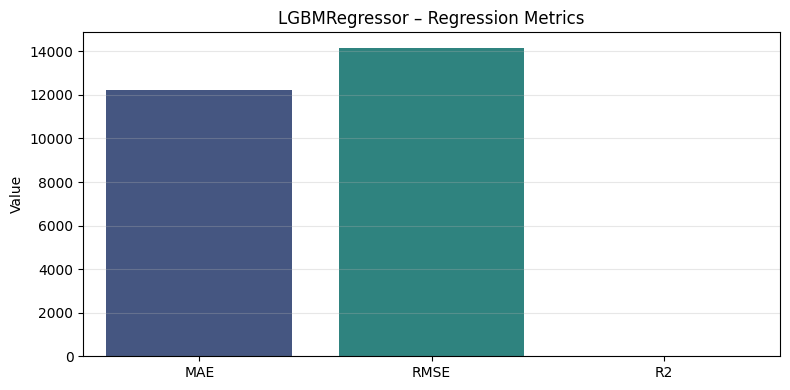

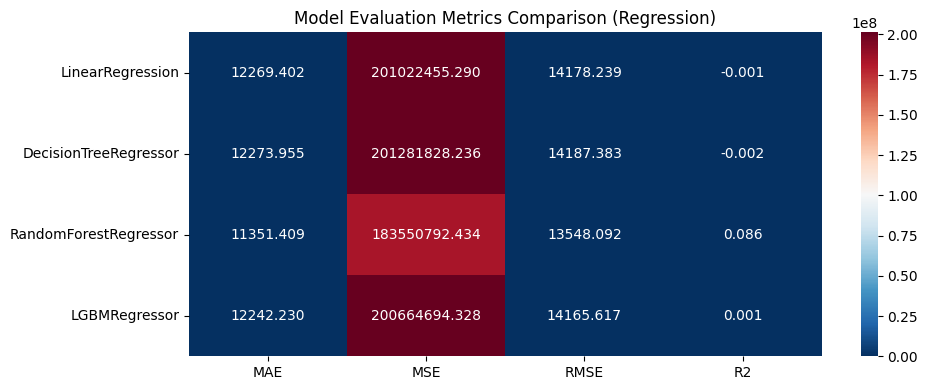

In [187]:
age_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_age_binning_del,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                               MAE        RMSE        R2
 LinearRegression         0.023209    0.010558 -0.000001
 DecisionTreeRegressor   -0.804501   -0.830725  0.000111
 RandomForestRegressor -276.492959 -141.491586  0.019178
 LGBMRegressor           -6.236682   -4.453220  0.000622)

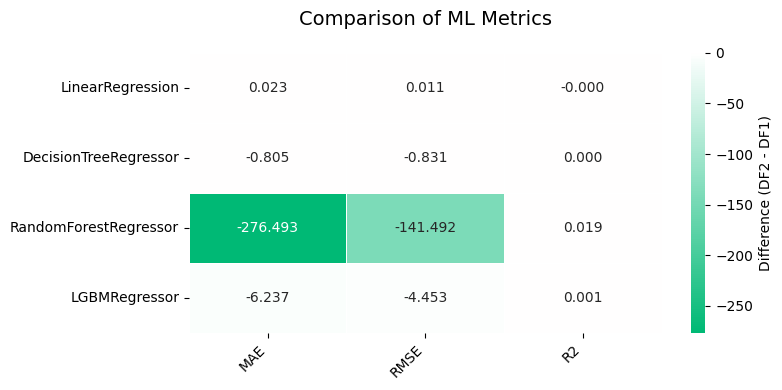

In [188]:
compare_metrics_heatmap(initial_metrics, age_metrics_del)

незначительные улучшения

### 2.5 Применение StandardScaler (стандартизация)

#### 2.5.1 Без удаления

In [232]:
X_standard_scaler = X.copy()

In [233]:
scaled_columns = ['AgeScaled', 'Admission_YearScaled', 'Admission_MonthScaled', 'Admission_DayOfWeekScaled', 'Discharge_YearScaled', 
                  'Discharge_MonthScaled', 'Discharge_DayOfWeekScaled']
X_standard_scaler[scaled_columns] = X_standard_scaler[['Age', 'Admission_Year', 'Admission_Month', 'Admission_DayOfWeek', 'Discharge_Year',
                                                       'Discharge_Month', 'Discharge_DayOfWeek']]

In [234]:
preprocessor_standard_scaler = clone(preprocessor)

preprocessor_standard_scaler['transformations'].transformers.append(
    ('scaler', StandardScaler(), scaled_columns)
)

preprocessor_standard_scaler['nan_remover'].transformers[0][2].extend(scaled_columns)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


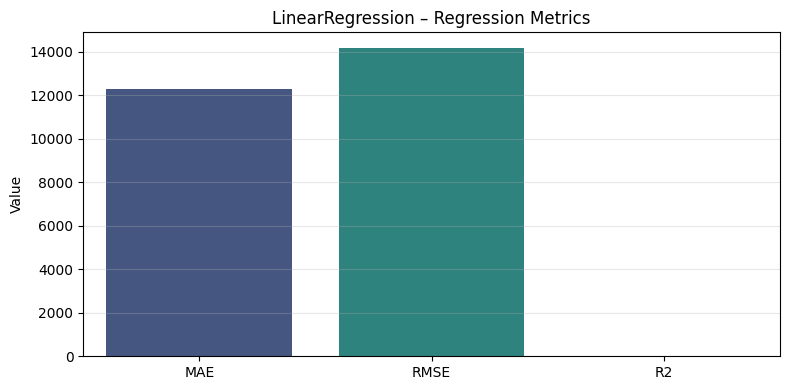

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


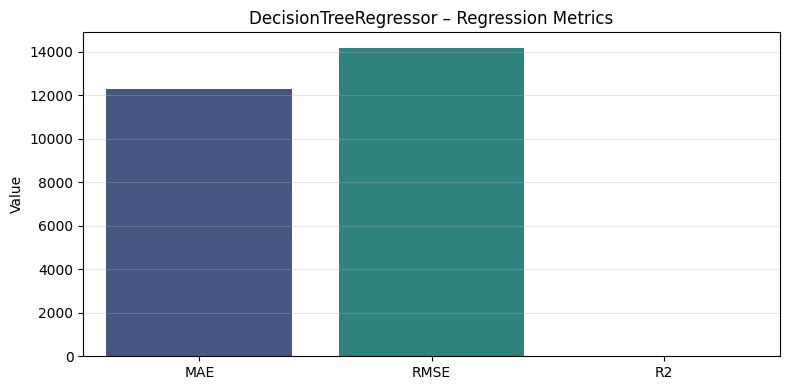

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


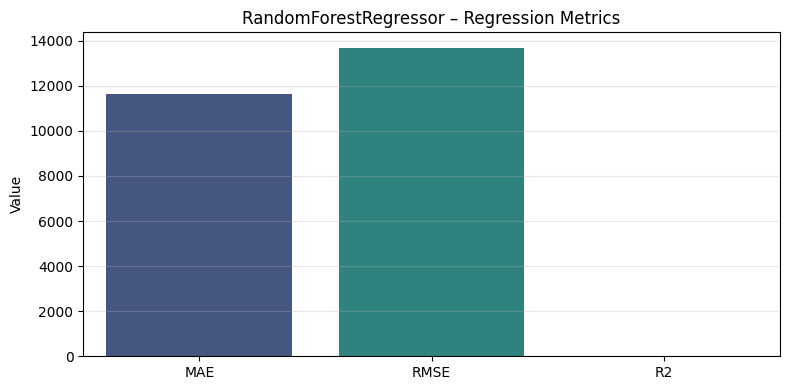

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


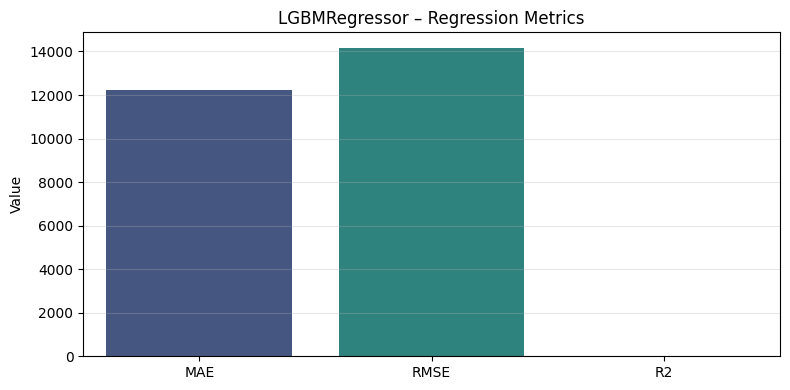

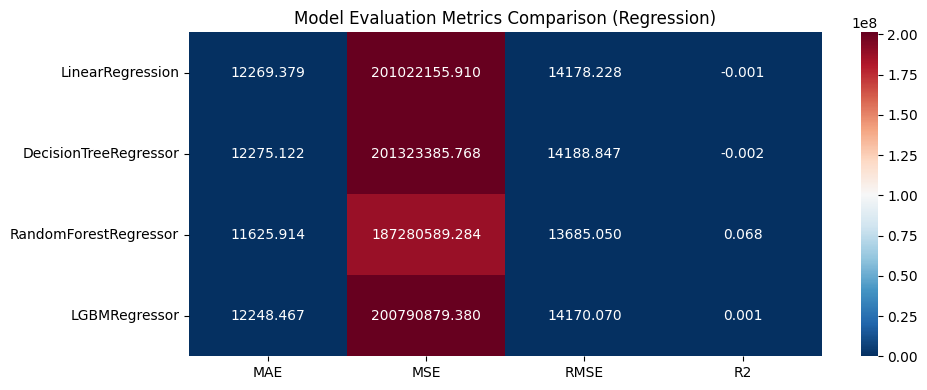

In [235]:
standard_scaler_metrics = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler,
    y=y,
    preprocessor=preprocessor_standard_scaler,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                                 MAE          RMSE            R2
 LinearRegression       1.818989e-12  1.818989e-12 -8.879616e-17
 DecisionTreeRegressor  3.624947e-01  6.337940e-01 -8.856504e-05
 RandomForestRegressor -1.988397e+00 -4.533578e+00  6.128855e-04
 LGBMRegressor          0.000000e+00  0.000000e+00  0.000000e+00)

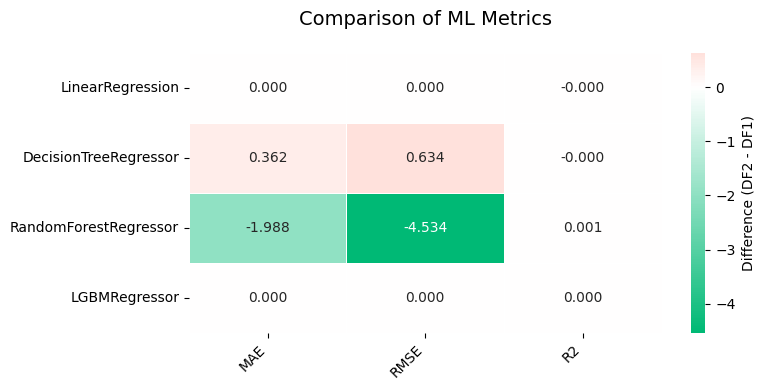

In [236]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics)

изменений нет

#### 2.5.2 С удалением

In [194]:
X_standard_scaler_del = X.copy()

In [195]:
preprocessor_standard_scaler_del = clone(preprocessor)

preprocessor_standard_scaler_del['transformations'].transformers.append(
    ('scaler', StandardScaler(), ['Age', 'Admission_Year', 'Admission_Month', 'Admission_DayOfWeek', 
                                  'Discharge_Year', 'Discharge_Month', 'Discharge_DayOfWeek'])
)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


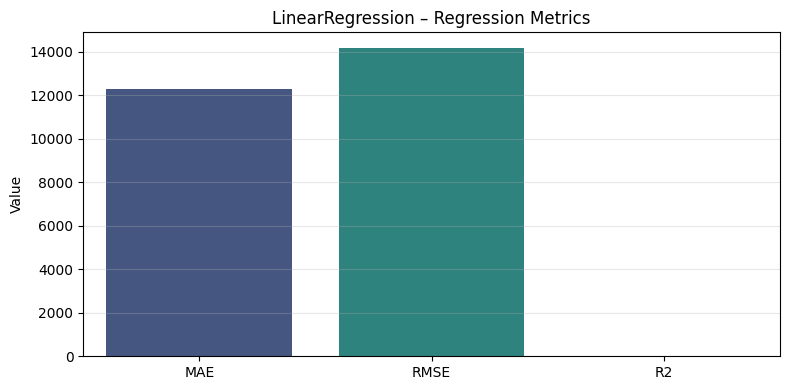

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


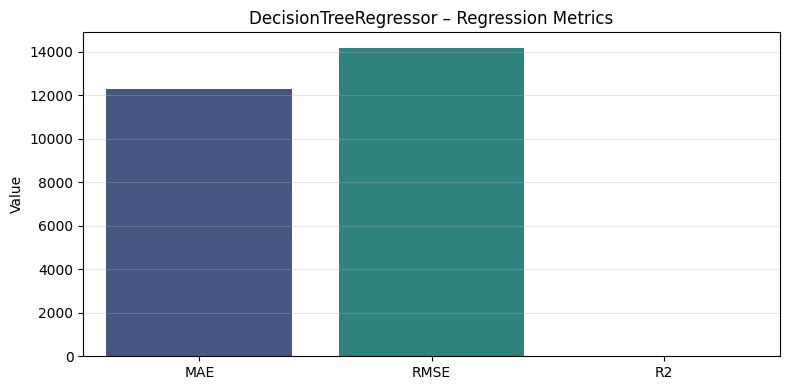

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


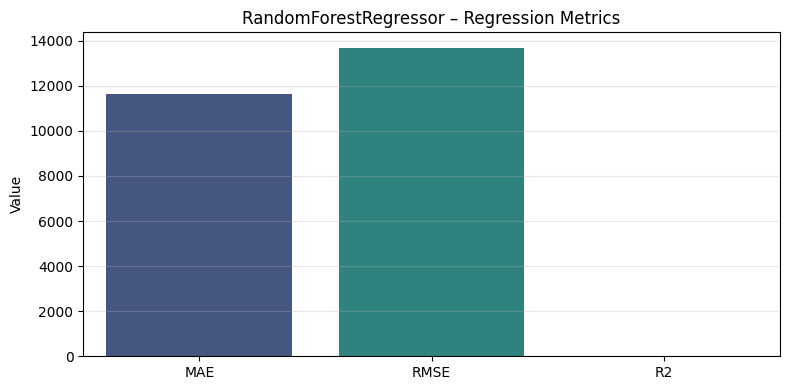

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


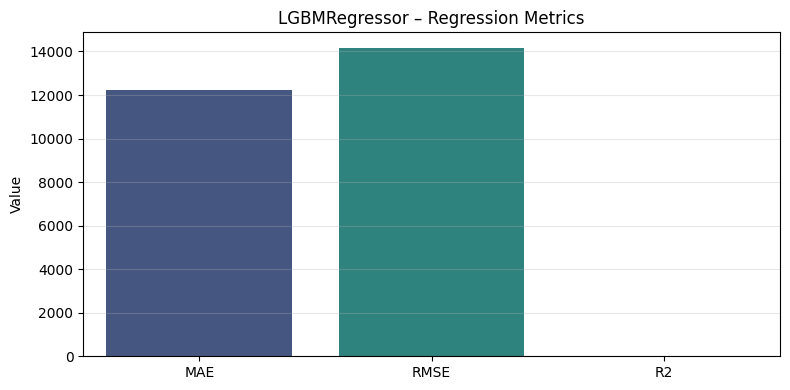

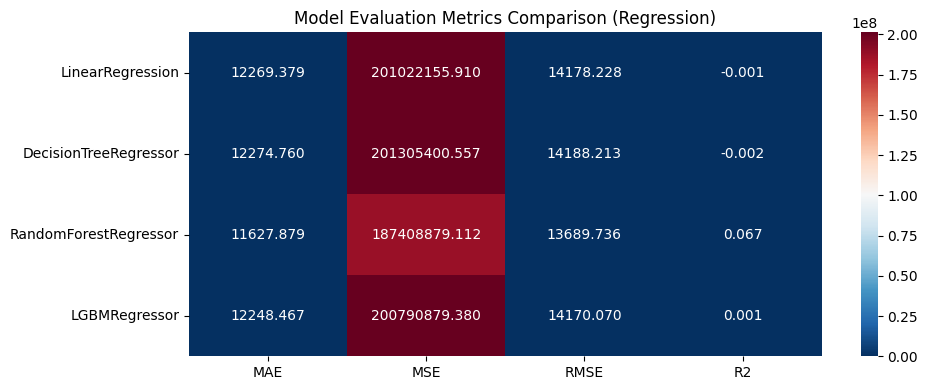

In [196]:
standard_scaler_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler_del,
    y=y,
    preprocessor=preprocessor_standard_scaler_del,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE            R2
 LinearRegression       0.000000  0.000000  2.220446e-16
 DecisionTreeRegressor  0.000000  0.000000  0.000000e+00
 RandomForestRegressor -0.023824  0.152845 -2.101444e-05
 LGBMRegressor          0.000000  0.000000  0.000000e+00)

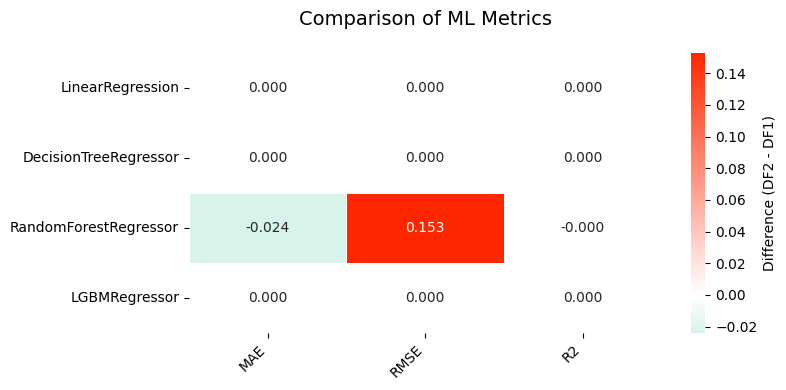

In [197]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics_del)

изменений особо нет

### 2.6 Нормализация

#### 2.6.1 Без удаления

In [237]:
X_normalised = X.copy()

In [238]:
scaled_columns = ['AgeScaled', 'Admission_YearScaled', 'Admission_MonthScaled', 'Admission_DayOfWeekScaled', 'Discharge_YearScaled', 
                  'Discharge_MonthScaled', 'Discharge_DayOfWeekScaled']
X_normalised[scaled_columns] = X_normalised[['Age', 'Admission_Year', 'Admission_Month',
                                              'Admission_DayOfWeek', 'Discharge_Year', 'Discharge_Month', 'Discharge_DayOfWeek']]

In [239]:
preprocessor_normalisation = clone(preprocessor)

preprocessor_normalisation['transformations'].transformers.append(
    ('scaler', MinMaxScaler(), scaled_columns)
)

preprocessor_normalisation['nan_remover'].transformers[0][2].extend(scaled_columns)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


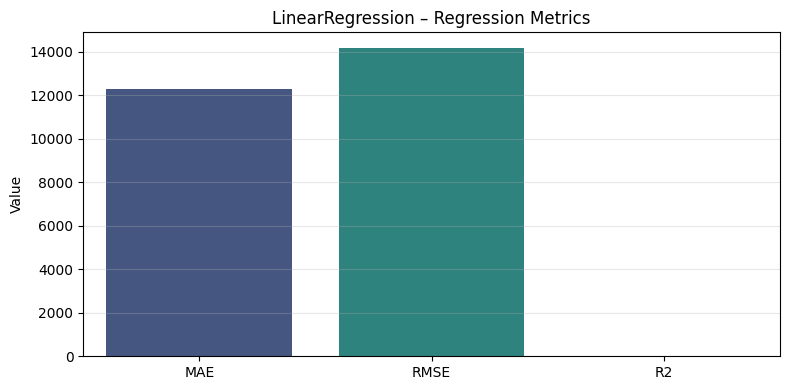

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


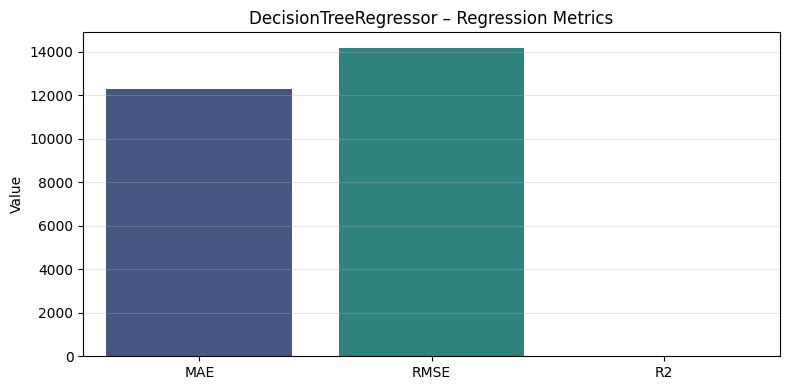

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


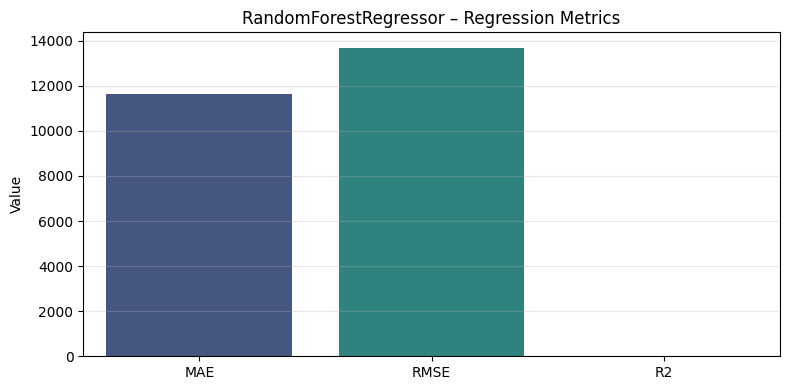

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


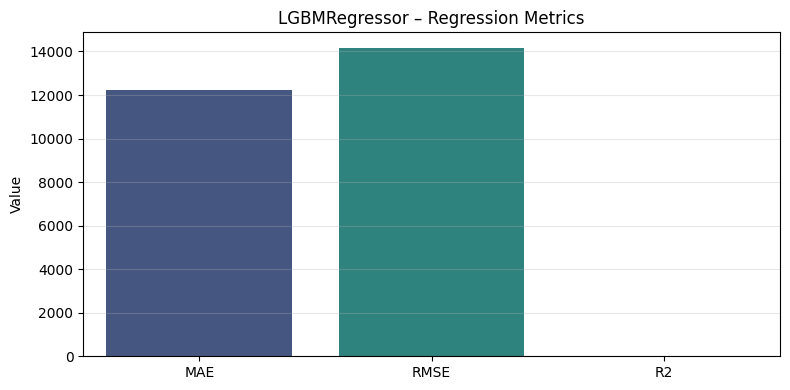

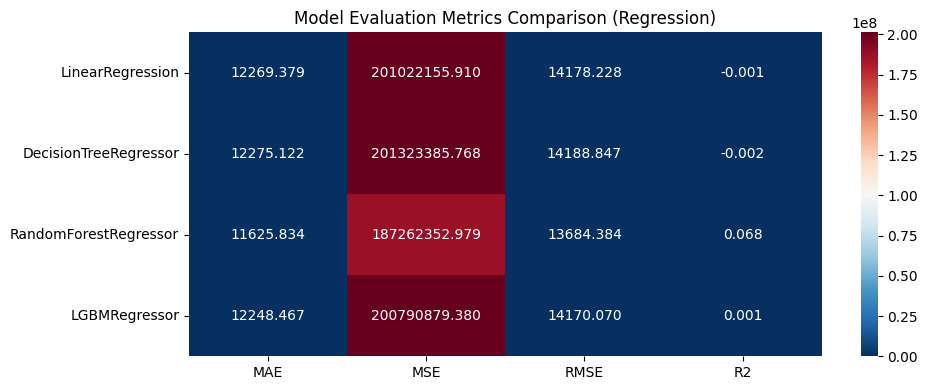

In [240]:
normalised_metrics = train_evaluate_models_cv(
    models=models,
    X=X_normalised,
    y=y,
    preprocessor=preprocessor_normalisation,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                                 MAE          RMSE            R2
 LinearRegression       5.456968e-12  3.637979e-12 -5.772292e-16
 DecisionTreeRegressor  3.624947e-01  6.337940e-01 -8.856504e-05
 RandomForestRegressor -2.068617e+00 -5.199880e+00  7.032065e-04
 LGBMRegressor          0.000000e+00  0.000000e+00  0.000000e+00)

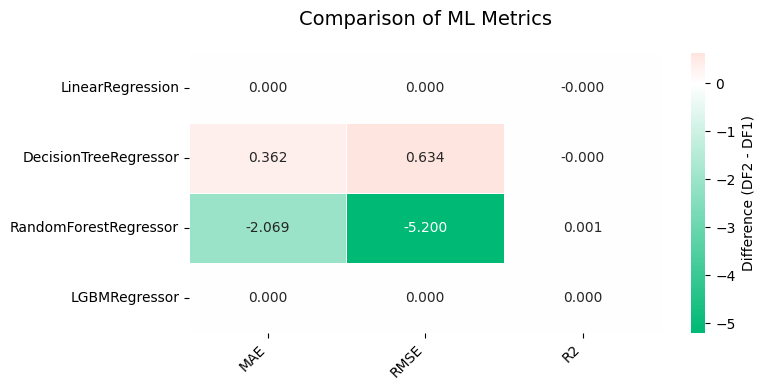

In [241]:
compare_metrics_heatmap(initial_metrics, normalised_metrics)

изменеий особо нет

#### 2.6.2 С удалением

In [203]:
X_normalised_del = X.copy()

In [204]:
preprocessor_normalisation_del = clone(preprocessor)

preprocessor_normalisation_del['transformations'].transformers.append(
    ('scaler', MinMaxScaler(), ['Age', 'Admission_Year', 'Admission_Month', 'Admission_DayOfWeek',
                                 'Discharge_Year', 'Discharge_Month', 'Discharge_DayOfWeek'])
)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


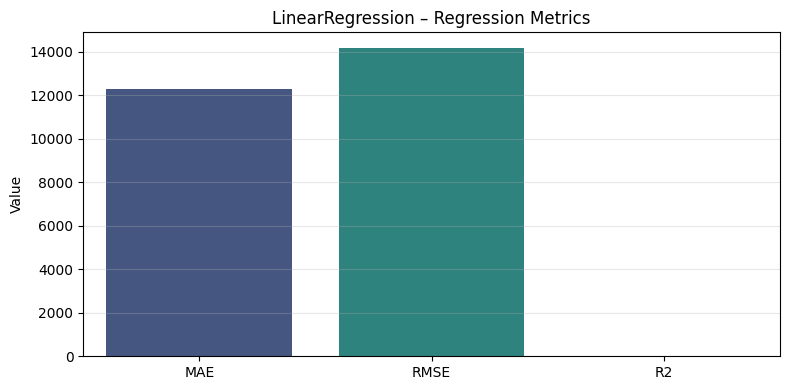

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


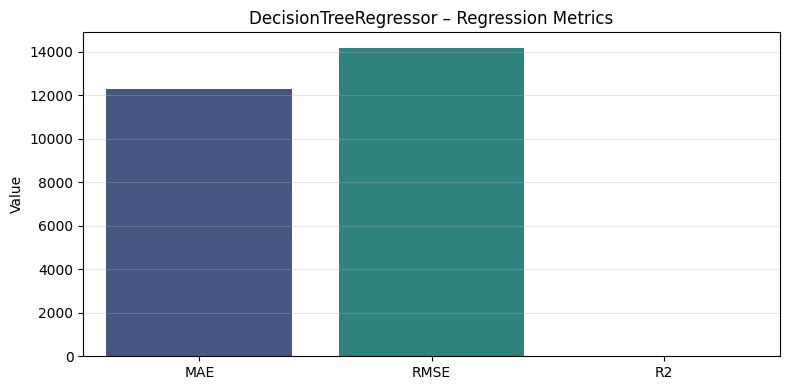

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


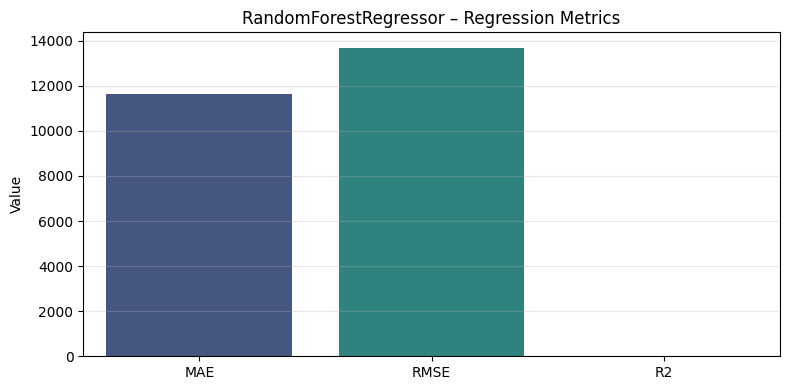

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


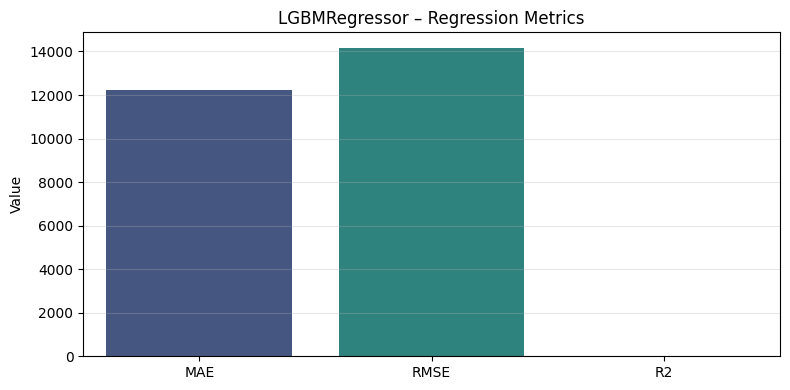

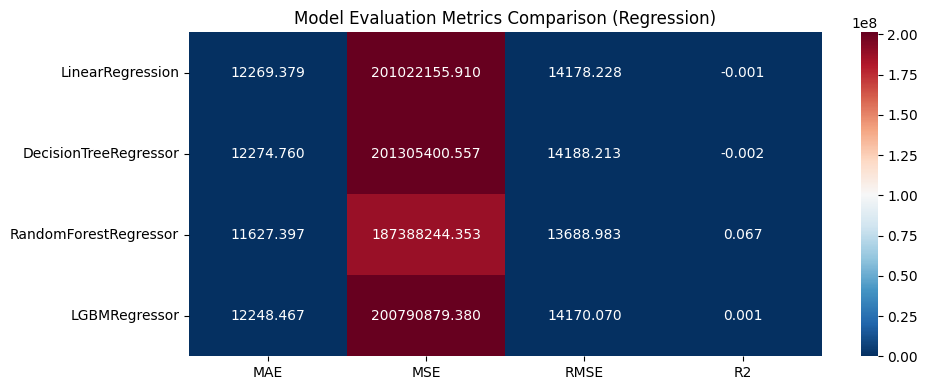

In [205]:
normalised_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_normalised_del,
    y=y,
    preprocessor=preprocessor_normalisation_del,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                             MAE      RMSE            R2
 LinearRegression       0.000000  0.000000  1.777007e-16
 DecisionTreeRegressor  0.000000  0.000000  0.000000e+00
 RandomForestRegressor -0.505017 -0.600834  8.100298e-05
 LGBMRegressor          0.000000  0.000000  0.000000e+00)

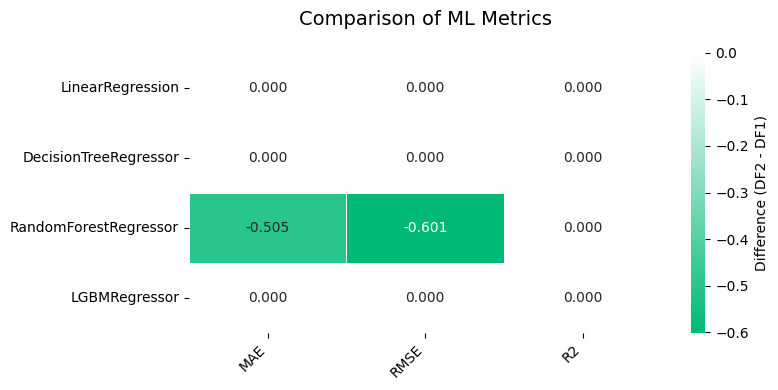

In [206]:
compare_metrics_heatmap(initial_metrics, normalised_metrics_del)

Ощутимых улучшений не наблюдается

### 2.9 Таргетное кодирование

In [223]:
preprocessor_target_encoding = clone(preprocessor)
preprocessor_target_encoding['transformations'].transformers[0] = ('encoder', TargetEncoder(categories=category_orders), categorical_cols)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


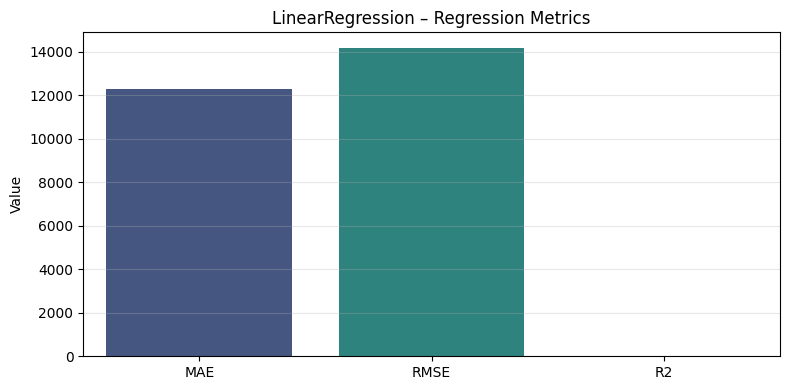

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


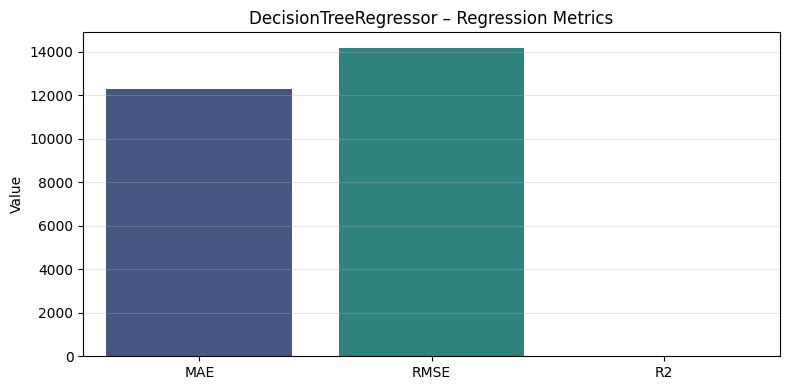

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


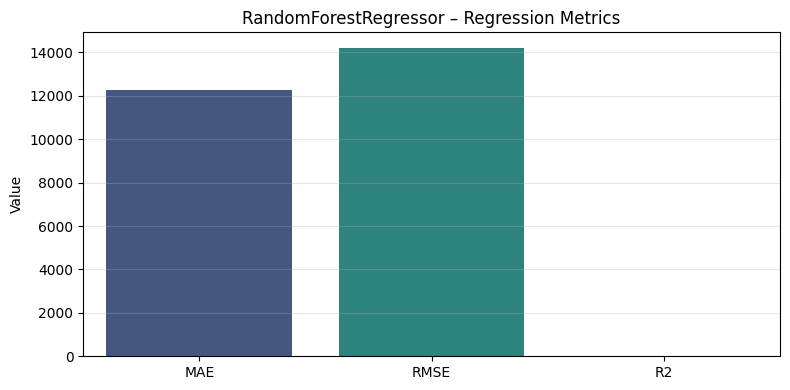

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


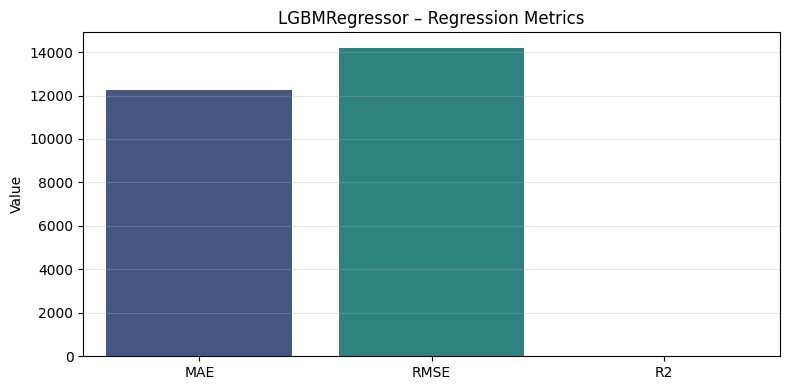

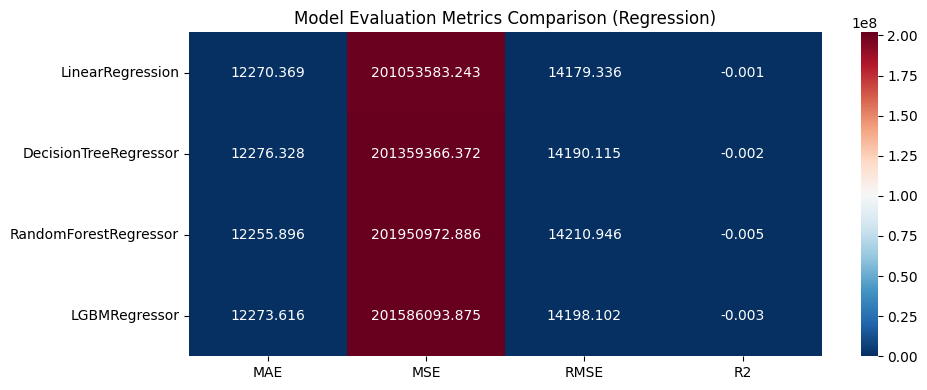

In [224]:
target_encoder_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor_target_encoding,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                               MAE        RMSE        R2
 LinearRegression         0.990328    1.108252 -0.000158
 DecisionTreeRegressor    1.567666    1.901656 -0.000273
 RandomForestRegressor  627.993855  521.362107 -0.072414
 LGBMRegressor           25.149336   28.031926 -0.003957)

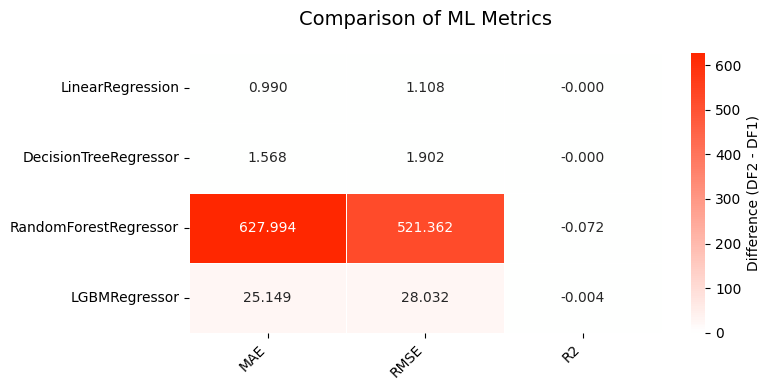

In [225]:
compare_metrics_heatmap(initial_metrics, target_encoder_metrics)

ухудшения в лесе

# 2.9 One-Hot Encoder

попробую заменить OrdinalEncoder на One-Hot

In [242]:
from sklearn.preprocessing import OneHotEncoder

In [243]:
numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor_one = Pipeline([
    ('transformations',
     ColumnTransformer(
         transformers=[
             ('num', 'passthrough', numeric_cols),
             ('cat', OneHotEncoder(
                 handle_unknown='ignore',
                 sparse_output=False
             ), categorical_cols),
         ],
         remainder='drop',
         verbose_feature_names_out=False,
     )
    )
])
preprocessor_one.set_output(transform="pandas")

,steps,"[('transformations', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


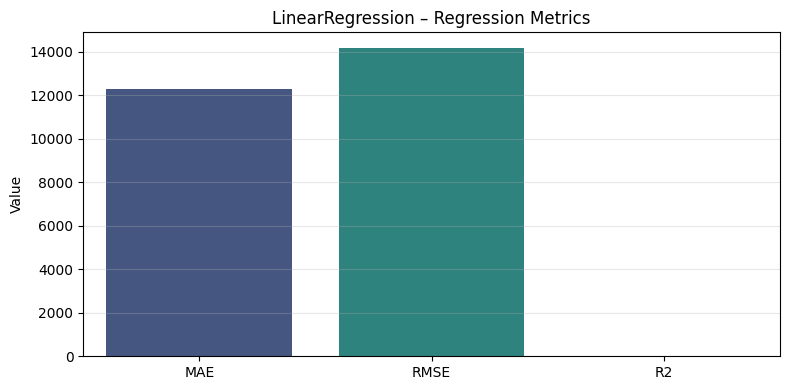

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


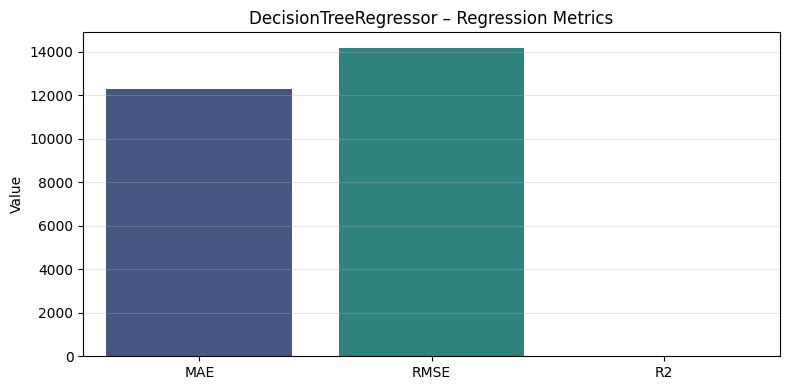

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


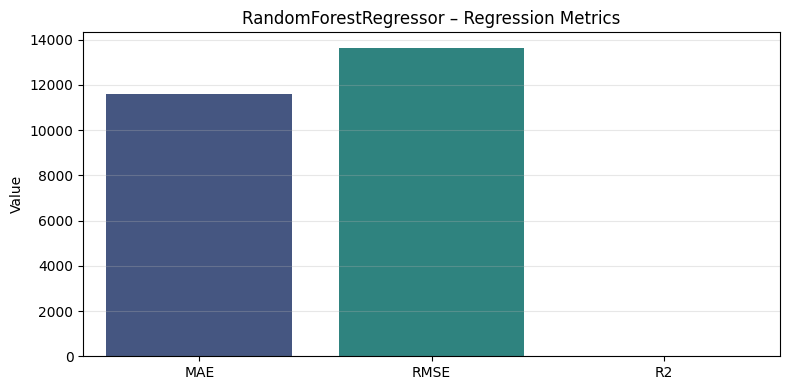

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


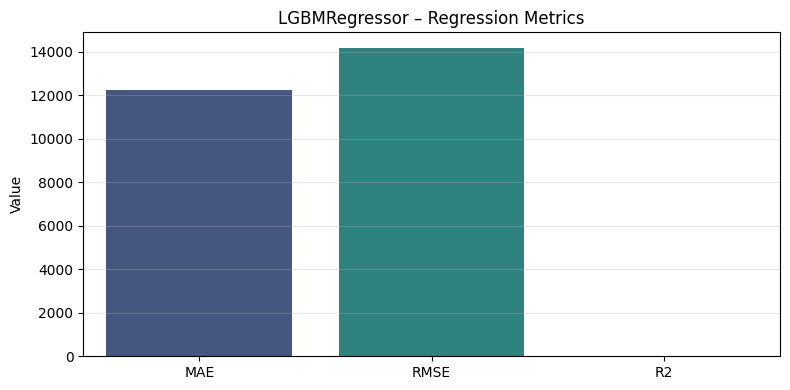

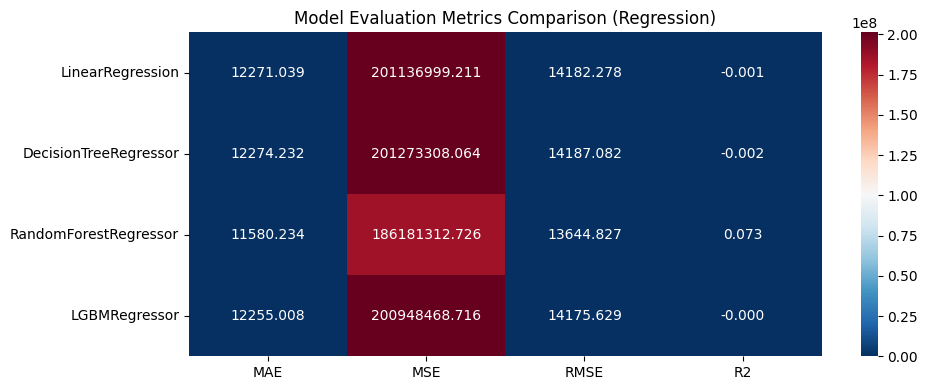

In [244]:
one_hot_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor_one,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                              MAE       RMSE        R2
 LinearRegression        1.660235   4.049409 -0.000573
 DecisionTreeRegressor  -0.528291  -1.131001  0.000149
 RandomForestRegressor -47.668351 -44.756099  0.006086
 LGBMRegressor           6.541434   5.559550 -0.000779)

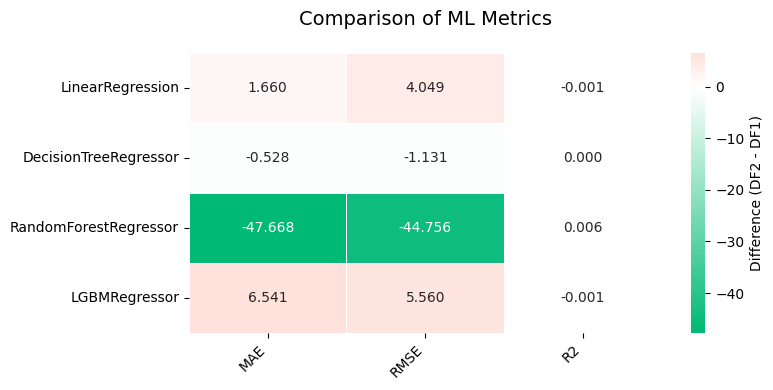

In [245]:
compare_metrics_heatmap(initial_metrics, one_hot_metrics)

особых изменений нет

### 2.11 Итоговый результат

Из всех преобразований только введение доп. фичи Length_of_stay и бинниг возраста дало хоть какое-то улучшение, их мы и применим к данным

In [268]:
df_preprocessed1 = df.copy()
# Удаляем полные дубликаты строк
df_preprocessed1 = df_preprocessed1.drop_duplicates()
# Удаляем строки с отрицательными значениями таргета Billing Amount
df_preprocessed1 = df_preprocessed1[df_preprocessed1['Billing Amount'] >= 0]
df_preprocessed1['Age'] = pd.to_numeric(df_preprocessed1['Age'])
# Преобразуем даты в тип datetime
df_preprocessed1['Date of Admission'] = pd.to_datetime(
    df_preprocessed1['Date of Admission'], errors='coerce'
)
df_preprocessed1['Discharge Date'] = pd.to_datetime(
    df_preprocessed1['Discharge Date'], errors='coerce'
)
# Делаем числовые признаки из даты
df_preprocessed1["Admission_Year"]      = df_preprocessed1["Date of Admission"].dt.year
df_preprocessed1["Admission_Month"]     = df_preprocessed1["Date of Admission"].dt.month
df_preprocessed1["Admission_DayOfWeek"] = df_preprocessed1["Date of Admission"].dt.dayofweek  # 0=Пн

df_preprocessed1["Discharge_Year"]      = df_preprocessed1["Discharge Date"].dt.year
df_preprocessed1["Discharge_Month"]     = df_preprocessed1["Discharge Date"].dt.month
df_preprocessed1["Discharge_DayOfWeek"] = df_preprocessed1["Discharge Date"].dt.dayofweek  # 0=Пн

df_preprocessed1['Length_of_stay'] = (
    df_preprocessed1['Discharge Date'] - df_preprocessed1['Date of Admission']
).dt.days.clip(lower=0)

# удаляем Hospital (тк он имеет 39876 уникальных значений, что очень много), номер комнаты, имя и доктора, тк они не несут какого-то значения
df_preprocessed1 = df_preprocessed1.drop(columns=['Hospital', 'Room Number', "Name", "Doctor"])

In [269]:
# Исходную дату выбрасываем
df_preprocessed1 = df_preprocessed1.drop(columns=["Date of Admission"])
df_preprocessed1 = df_preprocessed1.drop(columns=["Discharge Date"])

In [270]:
X_fin, y_fin = divide_data(df_preprocessed1, 'Billing Amount')

In [271]:
X_final = X_fin.copy()

In [272]:
bins = [0, 25, 40, 60, 120]
labels = [0, 1, 2 , 3]

X_final['Age'] = pd.cut(X_final['Age'], bins=bins, labels=labels, right=True)

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


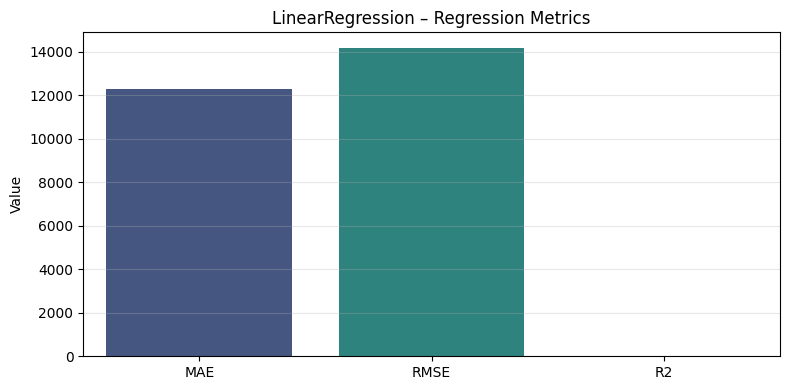

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


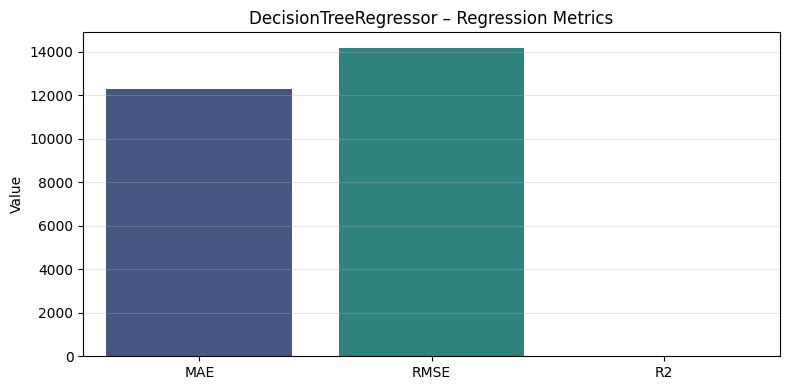

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


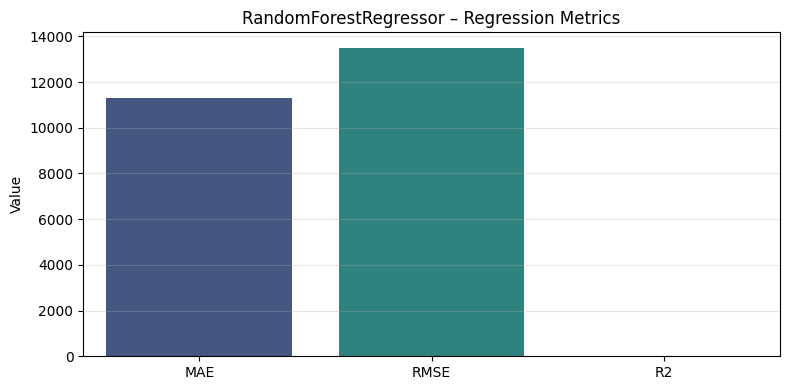

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


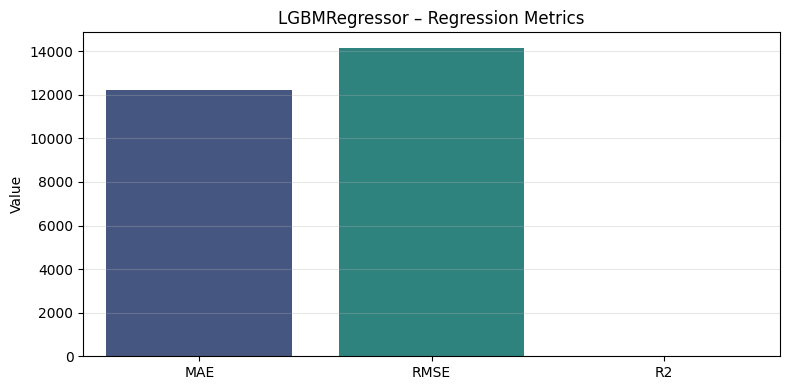

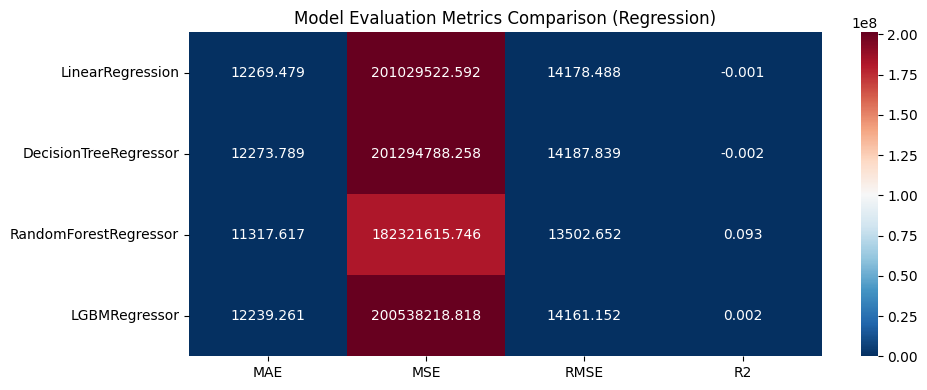

In [273]:
final_metrics = train_evaluate_models_cv(
    models=models,
    X=X_final,
    y=y_fin,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                               MAE        RMSE        R2
 LinearRegression         0.100345    0.259786 -0.000036
 DecisionTreeRegressor   -0.971221   -0.373988  0.000045
 RandomForestRegressor -310.285252 -186.931249  0.025295
 LGBMRegressor           -9.206225   -8.918096  0.001247)

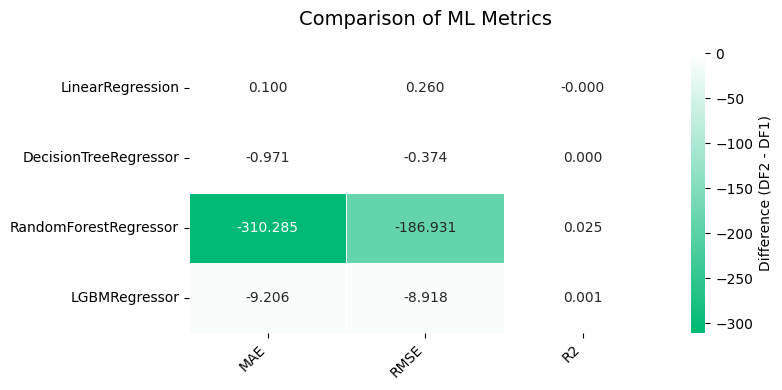

In [274]:
compare_metrics_heatmap(initial_metrics, final_metrics)